In [2]:
import os
import h5py
import glob
import matplotlib.pyplot as plt
from gwosc.timeline import get_segments
from gwpy.timeseries import TimeSeries
from lalframe.utils import frtools

### Fetch Open Data


In [8]:
ifo = "L1"
sample_rate = 4096
format = "gwf"
O3b_start = 1256655618
O3b_end = 1269363618

# Searching for the available segments
L1_segments = get_segments(
    f"{ifo}_DATA",
    start=O3b_start,
    end=O3b_end,
)
seg_id = 0
chosen_seg = L1_segments[seg_id]
print(f"Chosen segment: {chosen_seg}")
print(f"Length of segment {seg_id}: {chosen_seg[1] - chosen_seg[0]}")

# Create folders
working_dir = "/home/jerry/GW/glitch-classification/Omicron"
data_dir = f"/home/jerry/GW/glitch-classification/Data"
output_dir = f"{working_dir}/triggers"
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


Chosen segment: (1256655666, 1256657739)
Length of segment 0: 2073


In [ ]:
# Fetch time series data
print(f"Fetching {ifo} Data: {chosen_seg[0]} s to {chosen_seg[1]} s.")
ts = TimeSeries.fetch_open_data(
    ifo=ifo,
    start=chosen_seg[0],
    end=chosen_seg[1],
    sample_rate=sample_rate,
    format=format,
)

# Save time series data for Omicron analysis
gwf_file = f"{data_dir}/{ifo[0]}-{ifo}_GWOSC_DATA-{chosen_seg[0]}-{chosen_seg[1]-chosen_seg[0]}.gwf"
ts.write(gwf_file, format=format)
print(f"Data written to {gwf_file}.")

Fetching L1 Data: 1256655666 s to 1256657739 s.
Data written to /home/jerry/GW/glitch-classification/Data/L-L1_GWOSC_DATA-1256655666-2073.gwf.


### Run Omicron

In [47]:
start = chosen_seg[0]
end = chosen_seg[1]
# Get channel name from the downloaded data
gwf_file = f"{data_dir}/{ifo[0]}-{ifo}_GWOSC_DATA-{chosen_seg[0]}-{chosen_seg[1]-chosen_seg[0]}.gwf"
channel = frtools.get_channels(gwf_file)[0]
print(f"Channel name: {channel}")

Channel name: L1:GWOSC-4KHZ_R1_STRAIN


In [48]:
# Generating lcf file
os.chdir(working_dir)
lcf_content = f"{ifo} {channel} {start} {end-start} {gwf_file}"
lcf_file = f"{working_dir}/frames.lcf"
with open(lcf_file, 'w') as file:
    file.write(lcf_content)

# Generating parameters.txt
parameter_content = f"""\
# Omicron parameter file

PARAMETER CLUSTERING       TIME
PARAMETER FFTPLAN          FFTW_ESTIMATE
PARAMETER TRIGGERRATEMAX   100000
PARAMETER QRANGE           3.3166 108.0
PARAMETER FREQUENCYRANGE   32.0 2048.0
PARAMETER CLUSTERDT        0.5
PARAMETER MISMATCHMAX      0.2
PARAMETER SNRTHRESHOLD     5.0 
PARAMETER PSDLENGTH        124
PARAMETER TIMING           64 4

OUTPUT    DIRECTORY        {output_dir}
OUTPUT    PRODUCTS         triggers
OUTPUT    VERBOSITY        1
OUTPUT    FORMAT           hdf5
OUTPUT    NTRIGGERMAX      10000000.0

DATA      SAMPLEFREQUENCY  1024
DATA      FFL              {lcf_file}
DATA      CHANNELS         {channel}
"""
parameter_file = f"{working_dir}/parameters.txt"
with open(parameter_file, 'w') as file:
    file.write(parameter_content)

In [49]:
# Run Omicron
os.chdir(working_dir)
os.system(f"omicron {start} {end} {parameter_file} strict")

C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/home/jerry/miniforge3/envs/glitch-classification/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~




##############################################################
##############################################################

   ██████╗ ███╗   ███╗██╗ ██████╗██████╗  ██████╗ ███╗   ██╗
  ██╔═══██╗████╗ ████║██║██╔════╝██╔══██╗██╔═══██╗████╗  ██║
  ██║   ██║██╔████╔██║██║██║     ██████╔╝██║   ██║██╔██╗ ██║
  ██║   ██║██║╚██╔╝██║██║██║     ██╔══██╗██║   ██║██║╚██╗██║
  ╚██████╔╝██║ ╚═╝ ██║██║╚██████╗██║  ██║╚██████╔╝██║ ╚████║
   ╚═════╝ ╚═╝     ╚═╝╚═╝ ╚═══��═╝╚═╝  ╚═╝ ╚═════╝ ╚═╝  ╚═══╝
                                                    4.1.1
##############################################################
##############################################################


IO::ParseFile: Parse file /home/jerry/GW/glitch-classification/Omicron/parameters.txt		ok
Omicron::ReadOptions: number of options = 43
ffl::ffl: detect file format
ffl::Convert2Ffl: FFL conversion
ffl::Reset: reset ffl
ffl::LoadFrameFile: load FFL file
ffl::LoadFrameFile: extract frame information
ffl::LoadFrameFile:

0

### Gathering triggers

In [11]:
h5s = glob.glob(f"{output_dir}/{channel}/*.h5")
h5s = sorted(h5s)
triggers = []
for h5 in h5s:
    with h5py.File(h5, 'r') as f:
        # Look up for the keys
        # print(f.keys())
        triggers.extend(f['triggers'][:])

print(f"Number of the triggers from {start} to {end}: {len(triggers)}")
# Gather trigger times
trigger_times = [float(trigger['time']) for trigger in triggers]
# Gather trigger frequencies
trigger_frequencies = [float(trigger['frequency']) for trigger in triggers]
# Gather trigger snrs
trigger_snrs = [float(trigger['snr']) for trigger in triggers]

Number of the triggers from 1256655666 to 1256657739: 124


### Whiten Time Series Data

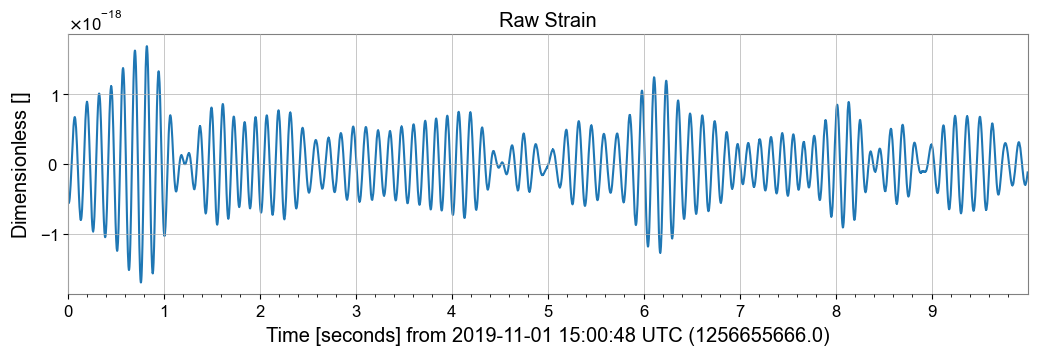

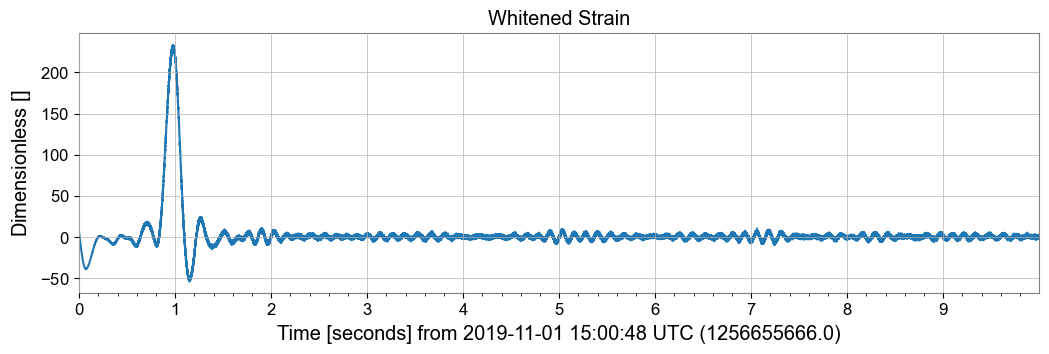

In [50]:
# Reading time series data
ts = TimeSeries.read(
    source=gwf_file,
    channel=channel,
    start=start,
    end=end,
)
ts[:10*sample_rate].plot(title='Raw Strain').show()

# Calculating ASD
fftlength = 32
overlap = fftlength/2
asd = ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)

# Whiten time series data
wh_ts = ts.whiten(asd=asd)
wh_ts[:10*sample_rate].plot(title='Whitened Strain').show()

### Get Spectrogram

Time: 1256656108.255859, Frequency: 89.27487917327174, SNR: 7.061805892207992


/home/jerry/miniforge3/envs/glitch-classification/lib/python3.10/site-packages/gwpy/plot/plot.py:297: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


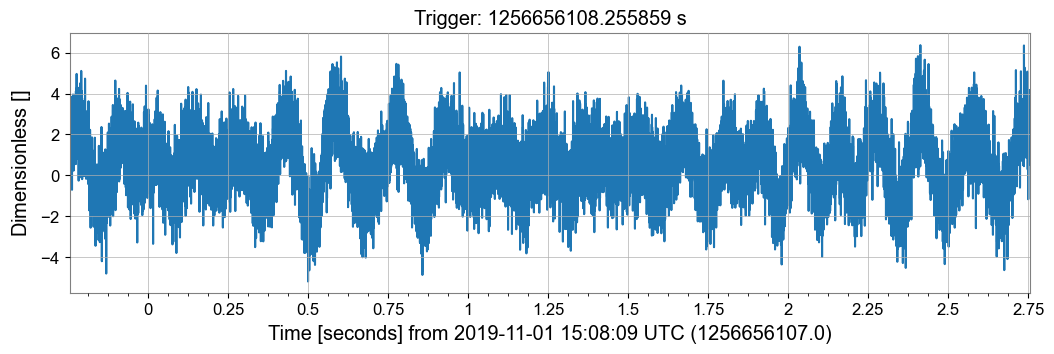

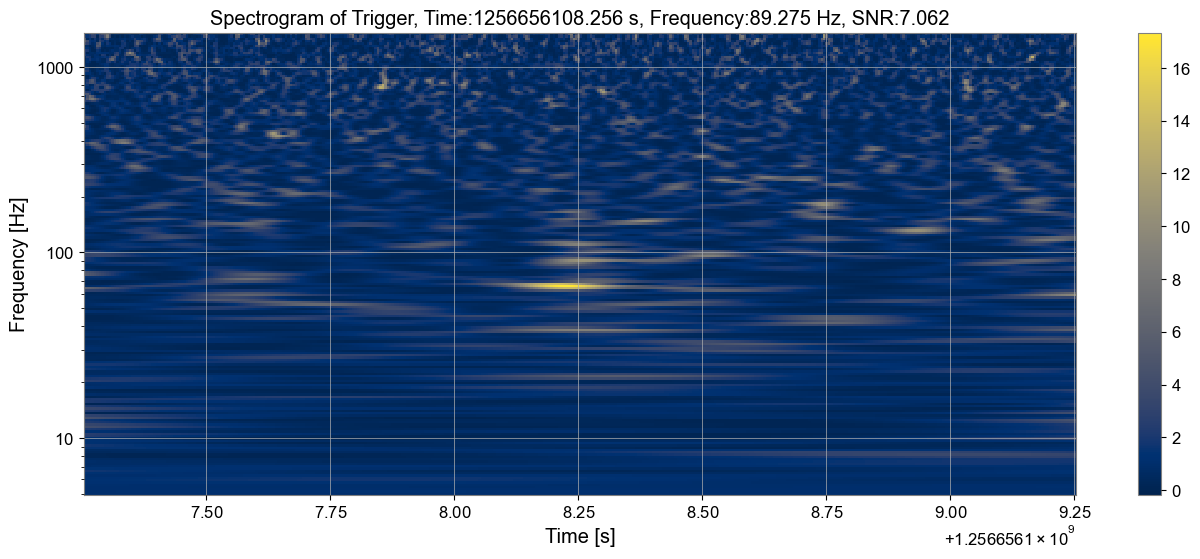

In [113]:
# Crop the time series first and then calculate the spectrogram
id = 20
trigger_time = trigger_times[id]
trigger_frequency = trigger_frequencies[id]
trigger_snr = trigger_snrs[id]
print(f"Time: {trigger_time}, Frequency: {trigger_frequency}, SNR: {trigger_snr}")

# Crop time series data
duration = 3
t0 = trigger_time - duration/2
crop_ts = wh_ts.crop(t0, t0+duration)
crop_ts.plot(title=f"Trigger: {trigger_time} s").show()

# Q-transform
qspec_short = crop_ts.q_transform(
    qrange=(50,50),
    frange=(5, 1500),
    tres=1/200,
    fres=200,
    logf=True,
    whiten=False,
)
crop_head, crop_tail = 0.5, 0.5
qspec_view = qspec_short.crop(t0+crop_head, t0+duration-crop_tail)
amplitude = qspec_view.T.to_value()
times = qspec_view.times.to_value()
frequencies = qspec_view.frequencies.to_value()
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram of Trigger, Time:{trigger_time:.3f} s, Frequency:{trigger_frequency:.3f} Hz, SNR:{trigger_snr:.3f}")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    # vmax=20,
    cmap='cividis',
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.yscale('log')
plt.colorbar(cmap='cividis')
plt.show()

In [112]:
# Calculate spectrogram of the whole whitened time series data
qspec = wh_ts.q_transform(
    qrange=(50,50),
    frange=(5, 1500),
    tres=1/200,
    fres=200,
    logf=True,
    whiten=False,
)

Time: 1256656108.255859, Frequency: 89.27487917327174, SNR: 7.061805892207992


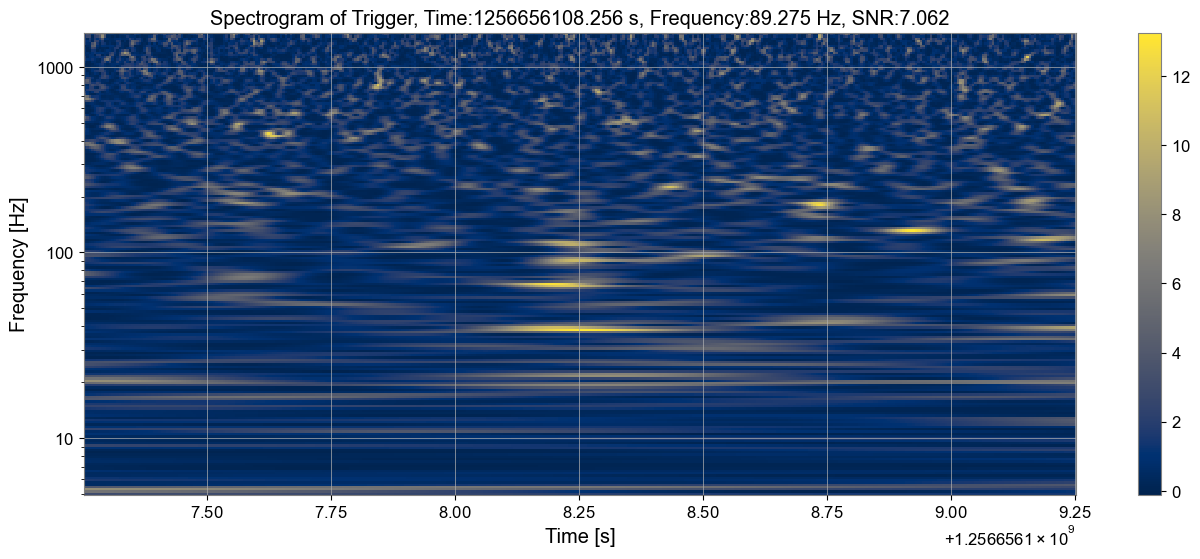

In [114]:
# Choosing triggers and plot the spectrogram
id = 20
trigger_time = trigger_times[id]
trigger_frequency = trigger_frequencies[id]
trigger_snr = trigger_snrs[id]
print(f"Time: {trigger_time}, Frequency: {trigger_frequency}, SNR: {trigger_snr}")

duration = 2
t0 = trigger_time - duration/2

qspec_view = qspec.crop(t0, t0+duration)
amplitude = qspec_view.T.to_value()
times = qspec_view.times.to_value()
frequencies = qspec_view.frequencies.to_value()
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram of Trigger, Time:{trigger_time:.3f} s, Frequency:{trigger_frequency:.3f} Hz, SNR:{trigger_snr:.3f}")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    # vmax=20,
    cmap='cividis',
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.yscale('log')
plt.colorbar(cmap='cividis')
plt.show()

In [90]:
print(trigger_snrs)
for i, snr in enumerate(trigger_snrs):
    if snr >= 100:
        print(i, snr)

[5.032229604127074, 44.40856106795152, 5.667487115351235, 8.80533455939033, 5.064844053021606, 9.162215900413171, 5.100228550345878, 9.117858446062034, 6.583309332701542, 6.337798281880494, 10.6039293440067, 104.147084391904, 10.319432777165126, 5.023766275198698, 5.358843429681596, 5.18188731955069, 5.045738558989289, 5.191920682069558, 5.132395045364208, 315.785014125254, 7.061805892207992, 30.338991355505236, 5.4202499056119935, 5.195136813471443, 5.230469272226459, 5.261548759377985, 5.044314196720507, 5.794337544053471, 5.60817108014871, 5.062899698318892, 5.0075053056701515, 5.025435127787002, 6.71068784184045, 5.111267727532588, 16.559937797007034, 5.125172612432482, 8.20980984360255, 64.63358404504501, 117.05658400737626, 5.0764735320290075, 5.065398636540723, 5.391072212065601, 5.063648747526636, 11.472420253652482, 5.303867776206812, 5.368959565104804, 5.311264412007554, 5.242519101905582, 5.200066435067701, 5.969666208652118, 5.010686146566114, 5.270293239208071, 5.062264919